# Timon Spichtinger Machine Learning 2 Modularbeit

In [13]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import importlib


from Datensatz import get_emnist_test_train, show_random_samples

In [14]:
X_train, y_train, X_test, y_test,classlist = get_emnist_test_train()

Ziel-ASCII: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Anzahl Zielklassen: 36
⚠️ Klasse B: nur 3878 echte Bilder – augmentiere 2122 zusätzlich.
⚠️ Klasse D: nur 4562 echte Bilder – augmentiere 1438 zusätzlich.
⚠️ Klasse E: nur 4934 echte Bilder – augmentiere 1066 zusätzlich.
⚠️ Klasse G: nur 2517 echte Bilder – augmentiere 3483 zusätzlich.
⚠️ Klasse H: nur 3152 echte Bilder – augmentiere 2848 zusätzlich.
⚠️ Klasse J: nur 3762 echte Bilder – augmentiere 2238 zusätzlich.
⚠️ Klasse K: nur 2468 echte Bilder – augmentiere 3532 zusätzlich.
⚠️ Klasse L: nur 5076 echte Bilder – augmentiere 924 zusätzlich.
⚠️ Klasse b: nur 5159 echte Bilder – augmentiere 841 zusätzlich.
⚠️ Klasse c: nur 2854 echte Bilder – augmentiere 3146 zusätzlich.
⚠️ Klasse f: nur 2561 echte Bilder – augmentiere 3439 zusätzlich.
⚠️ Klasse g: nur 3687 echte Bilder – augmentiere 2313 zusätzlich.
⚠️ Klasse i: nur 272

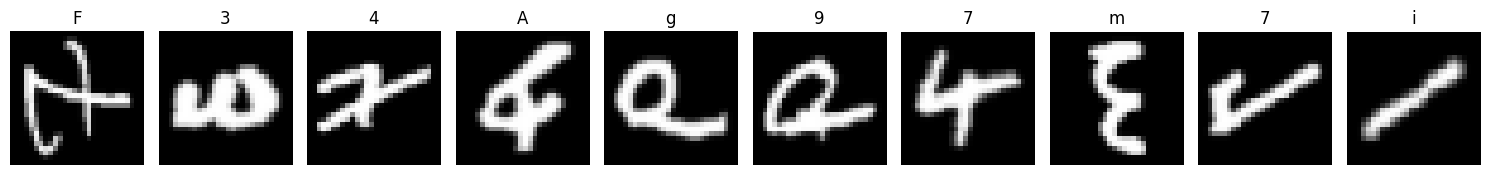

In [15]:

show_random_samples(X_test, y_test, classlist, n=10)

In [16]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from collections import defaultdict
import optuna
from Klassifikator import ResNet18  # oder AlexNet, GoogLeNet

# Gerät
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Klassenliste (36 Klassen)
class_list = list('0123456789ABCDEFGHIJKLMabcdefghijklm')

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


# -----------------------------
# Early Stopping
# -----------------------------
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# -----------------------------
# Optuna-Ziel-Funktion
# -----------------------------
def objective(trial):
    # Hyperparameter-Sampling
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 144, 256])
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    momentum = trial.suggest_float("momentum", 0.6, 0.95)
    step_size = trial.suggest_int("step_size", 2, 5)
    gamma = trial.suggest_float("gamma", 0.5, 0.95)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ResNet18(num_classes=len(class_list)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    early_stopping = EarlyStopping(patience=4)

    for epoch in range(20):  # ggf. mehr bei finalem Training
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Validierungs-Loss berechnen
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(test_loader)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"⛔ Early Stopping in Epoch {epoch+1}")
            break
        print(f"📉 Epoch {epoch+1}: Val Loss = {val_loss:.4f}")


    # Genauigkeit auf Testdaten
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


# -----------------------------
# Optuna-Studie starten
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# -----------------------------
# Finales Training mit besten Parametern (optional)
# -----------------------------
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

model = ResNet18(num_classes=len(class_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=best_params["momentum"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])
early_stopping = EarlyStopping(patience=4)

for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 200 == 0:
            print(f"🔁 Epoch {epoch+1}, Step {i+1}/{len(train_loader)}: Batch Loss = {loss.item():.4f}")

    scheduler.step()

    # Validierung
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    train_acc = 100.0 * correct_train / total_train
    val_acc = 100.0 * correct_val / total_val

    print(f"📊 Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, Val Loss = {val_loss:.4f}, LR = {scheduler.get_last_lr()}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"🛑 Early stopping ausgelöst bei Epoch {epoch+1} (Val Loss: {val_loss:.4f})")
        break

# Modell speichern
torch.save(model.state_dict(), './resnet18_best_hyperparams.pth')
print("✅ Modell gespeichert.")


[I 2025-06-05 17:32:19,725] A new study created in memory with name: no-name-460049ad-57c2-4ed4-9ce1-0fa7cd32de13


⛔ Early Stopping in Epoch 11


[I 2025-06-05 17:35:54,069] Trial 0 finished with value: 0.8629166666666667 and parameters: {'batch_size': 144, 'lr': 0.014698316807089204, 'momentum': 0.874277340260224, 'step_size': 5, 'gamma': 0.6768723939016551}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 12


[I 2025-06-05 17:38:53,507] Trial 1 finished with value: 0.8325555555555556 and parameters: {'batch_size': 256, 'lr': 0.00033424219531098814, 'momentum': 0.7643542955806851, 'step_size': 5, 'gamma': 0.9246937106893565}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 10


[I 2025-06-05 17:45:03,906] Trial 2 finished with value: 0.8496111111111111 and parameters: {'batch_size': 64, 'lr': 0.00022516734429942244, 'momentum': 0.9333259096785842, 'step_size': 5, 'gamma': 0.6112409725732096}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 8


[I 2025-06-05 17:47:39,258] Trial 3 finished with value: 0.84525 and parameters: {'batch_size': 144, 'lr': 0.0004143857091349456, 'momentum': 0.9102771947508954, 'step_size': 5, 'gamma': 0.9407238232263457}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 11


[I 2025-06-05 17:50:22,849] Trial 4 finished with value: 0.8572222222222222 and parameters: {'batch_size': 256, 'lr': 0.023123259668382204, 'momentum': 0.6213043963938398, 'step_size': 4, 'gamma': 0.7042600545097379}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 12


[I 2025-06-05 17:54:14,029] Trial 5 finished with value: 0.8373055555555555 and parameters: {'batch_size': 144, 'lr': 0.00026441074752157743, 'momentum': 0.7267296291605531, 'step_size': 2, 'gamma': 0.9334353408364608}. Best is trial 0 with value: 0.8629166666666667.


⛔ Early Stopping in Epoch 9


[I 2025-06-05 17:56:27,572] Trial 6 finished with value: 0.8665 and parameters: {'batch_size': 256, 'lr': 0.0205488561048036, 'momentum': 0.9319936071772215, 'step_size': 4, 'gamma': 0.663470904631867}. Best is trial 6 with value: 0.8665.


⛔ Early Stopping in Epoch 18


[I 2025-06-05 18:00:56,244] Trial 7 finished with value: 0.8338055555555556 and parameters: {'batch_size': 256, 'lr': 0.00013669687199750844, 'momentum': 0.8780580084516649, 'step_size': 4, 'gamma': 0.5939890075296753}. Best is trial 6 with value: 0.8665.


⛔ Early Stopping in Epoch 8


[I 2025-06-05 18:03:30,112] Trial 8 finished with value: 0.8554444444444445 and parameters: {'batch_size': 144, 'lr': 0.0031731181463308124, 'momentum': 0.6149502380602546, 'step_size': 2, 'gamma': 0.6618571521360993}. Best is trial 6 with value: 0.8665.


⛔ Early Stopping in Epoch 10


[I 2025-06-05 18:05:59,653] Trial 9 finished with value: 0.8608055555555556 and parameters: {'batch_size': 256, 'lr': 0.015284553379410242, 'momentum': 0.902892311649933, 'step_size': 5, 'gamma': 0.5951097285446874}. Best is trial 6 with value: 0.8665.


⛔ Early Stopping in Epoch 12


[I 2025-06-05 18:10:00,138] Trial 10 finished with value: 0.8697777777777778 and parameters: {'batch_size': 128, 'lr': 0.08883951844729966, 'momentum': 0.8236279947277043, 'step_size': 3, 'gamma': 0.5062463512070597}. Best is trial 10 with value: 0.8697777777777778.


⛔ Early Stopping in Epoch 11


[I 2025-06-05 18:13:40,547] Trial 11 finished with value: 0.8703888888888889 and parameters: {'batch_size': 128, 'lr': 0.09372982446705289, 'momentum': 0.808644091972167, 'step_size': 3, 'gamma': 0.50889620710297}. Best is trial 11 with value: 0.8703888888888889.


⛔ Early Stopping in Epoch 11


[I 2025-06-05 18:17:20,922] Trial 12 finished with value: 0.8696944444444444 and parameters: {'batch_size': 128, 'lr': 0.08452263650308278, 'momentum': 0.82117699619067, 'step_size': 3, 'gamma': 0.5140607691017608}. Best is trial 11 with value: 0.8703888888888889.


⛔ Early Stopping in Epoch 11


[I 2025-06-05 18:20:59,301] Trial 13 finished with value: 0.8707777777777778 and parameters: {'batch_size': 128, 'lr': 0.09348522521531417, 'momentum': 0.823902807903623, 'step_size': 3, 'gamma': 0.5136881005205461}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 8


[I 2025-06-05 18:23:40,190] Trial 14 finished with value: 0.8551666666666666 and parameters: {'batch_size': 128, 'lr': 0.0033766102454530003, 'momentum': 0.698904247064388, 'step_size': 3, 'gamma': 0.7800041605620166}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 12


[I 2025-06-05 18:27:39,863] Trial 15 finished with value: 0.8666944444444444 and parameters: {'batch_size': 128, 'lr': 0.04347779766355281, 'momentum': 0.826074572643684, 'step_size': 3, 'gamma': 0.802078374212669}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 9


[I 2025-06-05 18:30:39,743] Trial 16 finished with value: 0.8521944444444445 and parameters: {'batch_size': 128, 'lr': 0.0010869905897972038, 'momentum': 0.7865640769874449, 'step_size': 2, 'gamma': 0.5594259863174312}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 9


[I 2025-06-05 18:36:11,418] Trial 17 finished with value: 0.8666111111111111 and parameters: {'batch_size': 64, 'lr': 0.006401049717521514, 'momentum': 0.6931752013101573, 'step_size': 3, 'gamma': 0.5474573835684986}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 8


[I 2025-06-05 18:38:52,885] Trial 18 finished with value: 0.8545833333333334 and parameters: {'batch_size': 128, 'lr': 0.04160307021784333, 'momentum': 0.7829560907843005, 'step_size': 4, 'gamma': 0.7715540372701509}. Best is trial 13 with value: 0.8707777777777778.


⛔ Early Stopping in Epoch 7


[I 2025-06-05 18:41:12,980] Trial 19 finished with value: 0.8533055555555555 and parameters: {'batch_size': 128, 'lr': 0.0013526640851865795, 'momentum': 0.8534965150496183, 'step_size': 2, 'gamma': 0.877759386718596}. Best is trial 13 with value: 0.8707777777777778.


🎯 Beste Hyperparameter:
batch_size: 128
lr: 0.09348522521531417
momentum: 0.823902807903623
step_size: 3
gamma: 0.5136881005205461
🔁 Epoch 1, Step 200/1407: Batch Loss = 0.7476
🔁 Epoch 1, Step 400/1407: Batch Loss = 0.7168
🔁 Epoch 1, Step 600/1407: Batch Loss = 0.4487
🔁 Epoch 1, Step 800/1407: Batch Loss = 0.5777
🔁 Epoch 1, Step 1000/1407: Batch Loss = 0.3855
🔁 Epoch 1, Step 1200/1407: Batch Loss = 0.3975
🔁 Epoch 1, Step 1400/1407: Batch Loss = 0.3404
📊 Epoch 1: Train Acc = 77.29%, Val Acc = 83.00%, Val Loss = 0.4252, LR = [0.09348522521531417]
🔁 Epoch 2, Step 200/1407: Batch Loss = 0.3754
🔁 Epoch 2, Step 400/1407: Batch Loss = 0.4212
🔁 Epoch 2, Step 600/1407: Batch Loss = 0.3830
🔁 Epoch 2, Step 800/1407: Batch Loss = 0.3210
🔁 Epoch 2, Step 1000/1407: Batch Loss = 0.2682
🔁 Epoch 2, Step 1200/1407: Batch Loss = 0.3850
🔁 Epoch 2, Step 1400/1407: Batch Loss = 0.5214
📊 Epoch 2: Train Acc = 83.97%, Val Acc = 83.75%, Val Loss = 0.4145, LR = [0.09348522521531417]
🔁 Epoch 3, Step 200/1407: Bat

In [18]:
import torch
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, device, class_list):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Keine Gradientenberechnung, da wir nur evaluieren
        n_correct = 0
        n_samples = 0
        n_class_correct = defaultdict(int)
        n_class_samples = defaultdict(int)

        # Iteriere über den Testdatensatz
        for images, labels in test_loader:
            images = images.to(device)  # Bilder auf das gleiche Gerät verschieben (GPU oder CPU)
            labels = labels.to(device)  # Labels auf das gleiche Gerät verschieben (GPU oder CPU)
            
            # Vorwärtsdurchlauf
            outputs = model(images)
            
            # Vorhersagen
            _, predicted = torch.max(outputs, 1)

            # Update der Gesamtmetriken
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Update der Metriken pro Klasse
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

            # Speichere alle Labels und Vorhersagen für die Berechnung der weiteren Metriken
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Berechnung der Gesamtgenauigkeit
        acc = 100.0 * n_correct / n_samples
        print(f'Gesamtgenauigkeit des Netzwerks: {acc:.2f} %')

        # Berechnung der Klasse-genauen Genauigkeit
        for label in sorted(n_class_samples.keys()):
            ascii_char = class_list[label]
            class_acc = 100.0 * n_class_correct[label] / n_class_samples[label]
            print(f'Genauigkeit für Klasse {ascii_char}: {class_acc:.2f} %')

        # Berechnung der Precision, Recall und F1-Score für jede Klasse
        precision = precision_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        recall = recall_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        f1 = f1_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        
        # Berechne den durchschnittlichen F1-Score
        avg_f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        print("\nPrecision, Recall, F1-Score pro Klasse:")
        for i, ascii_char in enumerate(class_list):
            print(f"Klasse {ascii_char}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")
        
        print(f"\nDurchschnittlicher F1-Score (gewichtet): {avg_f1:.2f}")

        # Berechnung der Konfusionsmatrix
        cm = confusion_matrix(all_labels, all_predictions)
        print(f"\nKonfusionsmatrix:\n{cm}")

        # Berechnung der ROC-AUC (für Multiklassen kann man dies auch für jedes Label einzeln berechnen)
        try:
            roc_auc = roc_auc_score(all_labels, model_output_to_probs(model, test_loader, device), multi_class='ovr', average='weighted')
            print(f"\nDurchschnittliche ROC-AUC: {roc_auc:.2f}")
        except ValueError:
            print("\nROC-AUC konnte nicht berechnet werden (möglicherweise nicht geeignet für das Problem).")

        return acc

# Hilfsfunktion zur Berechnung der ROC-AUC für das Multiklassenproblem
def model_output_to_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_probs)

# Beispielaufruf
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Wähle GPU, wenn verfügbar

# Modell auf das Gerät (GPU/CPU) verschieben
model = model.to(device)

# Jetzt den Evaluierungscode aufrufen
evaluate_model(model, test_loader, device, class_list)


Gesamtgenauigkeit des Netzwerks: 87.21 %
Genauigkeit für Klasse 0: 95.80 %
Genauigkeit für Klasse 1: 64.40 %
Genauigkeit für Klasse 2: 98.90 %
Genauigkeit für Klasse 3: 99.10 %
Genauigkeit für Klasse 4: 99.20 %
Genauigkeit für Klasse 5: 98.50 %
Genauigkeit für Klasse 6: 95.00 %
Genauigkeit für Klasse 7: 99.30 %
Genauigkeit für Klasse 8: 98.40 %
Genauigkeit für Klasse 9: 95.00 %
Genauigkeit für Klasse A: 99.00 %
Genauigkeit für Klasse B: 97.30 %
Genauigkeit für Klasse C: 83.60 %
Genauigkeit für Klasse D: 95.30 %
Genauigkeit für Klasse E: 97.30 %
Genauigkeit für Klasse F: 81.40 %
Genauigkeit für Klasse G: 94.60 %
Genauigkeit für Klasse H: 97.50 %
Genauigkeit für Klasse I: 64.70 %
Genauigkeit für Klasse J: 87.60 %
Genauigkeit für Klasse K: 79.60 %
Genauigkeit für Klasse L: 95.20 %
Genauigkeit für Klasse M: 92.50 %
Genauigkeit für Klasse a: 94.90 %
Genauigkeit für Klasse b: 92.00 %
Genauigkeit für Klasse c: 69.60 %
Genauigkeit für Klasse d: 98.30 %
Genauigkeit für Klasse e: 97.30 %
Genauig

87.20555555555555

In [19]:
evaluate_model(model, test_loader, device, class_list)  

Gesamtgenauigkeit des Netzwerks: 87.21 %
Genauigkeit für Klasse 0: 95.80 %
Genauigkeit für Klasse 1: 64.40 %
Genauigkeit für Klasse 2: 98.90 %
Genauigkeit für Klasse 3: 99.10 %
Genauigkeit für Klasse 4: 99.20 %
Genauigkeit für Klasse 5: 98.50 %
Genauigkeit für Klasse 6: 95.00 %
Genauigkeit für Klasse 7: 99.30 %
Genauigkeit für Klasse 8: 98.40 %
Genauigkeit für Klasse 9: 95.00 %
Genauigkeit für Klasse A: 99.00 %
Genauigkeit für Klasse B: 97.30 %
Genauigkeit für Klasse C: 83.60 %
Genauigkeit für Klasse D: 95.30 %
Genauigkeit für Klasse E: 97.30 %
Genauigkeit für Klasse F: 81.40 %
Genauigkeit für Klasse G: 94.60 %
Genauigkeit für Klasse H: 97.50 %
Genauigkeit für Klasse I: 64.70 %
Genauigkeit für Klasse J: 87.60 %
Genauigkeit für Klasse K: 79.60 %
Genauigkeit für Klasse L: 95.20 %
Genauigkeit für Klasse M: 92.50 %
Genauigkeit für Klasse a: 94.90 %
Genauigkeit für Klasse b: 92.00 %
Genauigkeit für Klasse c: 69.60 %
Genauigkeit für Klasse d: 98.30 %
Genauigkeit für Klasse e: 97.30 %
Genauig

87.20555555555555

In [20]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.
